[View in Colaboratory](https://colab.research.google.com/github/sleepless-se/Abstract/blob/master/stock_filter_017.ipynb)

##新しく作り直した学習データを試す


In [1]:

!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-jumandic mecab-jumandic-utf8 mecab-utils
The following NEW packages will be installed:
  libmecab2 mecab mecab-jumandic mecab-jumandic-utf8 mecab-utils
0 upgraded, 5 newly installed, 0 to remove and 0 not upgraded.
Need to get 16.5 MB of archives.
After this operation, 218 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 libmecab2 amd64 0.996-3.1 [256 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 mecab-utils amd64 0.996-3.1 [4,750 B]
Get:3 http://archive.ubuntu.com/ubuntu artful/universe amd64 mecab-jumandic-utf8 all 7.0-20130310-3 [16.1 MB]
Get:4 http://archive.ubuntu.com/ubuntu artful/universe amd64 mecab-jumandic all 7.0-20130310-3 [2,044 B]
Get:5 http://archive.ubuntu.com/ubuntu artful/universe amd64 mecab amd64 0.996-3.1 [83.6 kB]
Fetched 16.5 M

In [0]:
import sys
import MeCab
import pickle
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Model,model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import time
import numpy as np
from google.colab import files
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_accuracy
import pickle

    
mecab = MeCab.Tagger ("-Owakati")

##Tokenizerの読み書き用関数

In [0]:

def save_text_tokenizer(tokenizer,file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)

## ドライブをマウント

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/stock_filter/017/"
!ls "/content/gdrive/My Drive/data/stock_filter/017/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
label_token.pickle  none_label.csv  stock_color_label.csv


##学習データの読み込み


In [6]:
import pandas as pd

file_name = 'stock_color_label.csv'
stock_df = pd.read_csv(base_dir+file_name,sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})

file_name = 'none_label.csv'
null_df = pd.read_csv(base_dir+file_name,sep=',',error_bad_lines=False,dtype={"iid": str,"style": str, "text": str})
null_df["label"] = "skip"

df = stock_df.append(null_df, ignore_index=True)
df.columns


b'Skipping line 19: expected 31 fields, saw 70\nSkipping line 36: expected 31 fields, saw 121\nSkipping line 49: expected 31 fields, saw 65\nSkipping line 89: expected 31 fields, saw 95\nSkipping line 97: expected 31 fields, saw 690\nSkipping line 121: expected 31 fields, saw 50\nSkipping line 153: expected 31 fields, saw 94\nSkipping line 176: expected 31 fields, saw 179\nSkipping line 206: expected 31 fields, saw 288\nSkipping line 216: expected 31 fields, saw 4419\nSkipping line 241: expected 31 fields, saw 107\nSkipping line 244: expected 31 fields, saw 136\nSkipping line 267: expected 31 fields, saw 129\nSkipping line 277: expected 31 fields, saw 131\nSkipping line 332: expected 31 fields, saw 59\nSkipping line 336: expected 31 fields, saw 153\nSkipping line 372: expected 31 fields, saw 313\nSkipping line 377: expected 31 fields, saw 33\nSkipping line 483: expected 31 fields, saw 209\nSkipping line 542: expected 31 fields, saw 59\nSkipping line 547: expected 31 fields, saw 41\nSki

Index(['id', 'label', 'tag', 'iid', 'style', 'x', 'y', 'height', 'width',
       'page_id', 'text', 'p_text', 'p_height', 'p_iid', 'p_style', 'p_tag',
       'p_width', 'p_x', 'p_y', 'href', 'disable', 'pp_tag', 'pp_style', 'src',
       'pp_height', 'pp_iid', 'pp_width', 'pp_x', 'pp_y', 'alt', 'pp_text'],
      dtype='object')

## 分かち書きをしたりするテキストの前処理

In [0]:

def to_df(token,se):
  matrix = token.texts_to_matrix(se,mode='count')
  temp_df = pd.DataFrame(matrix)
  return temp_df

def add_space_front_uppercase(text:str)->str:
  return ''.join(' ' + char if char.isupper() else char.strip() for char in text).strip()

def add_space_color_size(text:str)->str:
  return text.replace("colour","color").replace("color"," color ").replace("size"," size ")

def wakati(text)->str:
  text = str(text)
  if len(text)>3:
    text = mecab.parse(text)
  return replace_numbers_to_0(text)

def replace_numbers_to_0(text:str)->str:
  return re.sub(r'[0-9]+', "0",str(text))

def pre_text(df):
  wakachi_fileds = ['alt', 'href', 'iid','p_iid', 'p_style', 'p_tag', 'pp_iid', 'pp_style', 'pp_tag','src', 'style', 'tag', 'text','p_text']
  df[wakachi_fileds] = df[wakachi_fileds].applymap(lambda x : wakati(x)).fillna("")

  add_space_fileds = ["iid","style","p_iid","p_style","pp_iid","pp_style"]
  df[add_space_fileds] = df[add_space_fileds].applymap(lambda x : add_space_front_uppercase(x))
  df[add_space_fileds] = df[add_space_fileds].applymap(lambda x : add_space_color_size(x))
  return df                


## 学習データ全体の前処理

In [0]:

def prepare_data(data):
  df = pd.DataFrame(data)
  df = pre_text(df)

  fields = ['height', 'width', 'x', 'y',  'p_x', 'p_y', 'p_width','p_height','pp_height', 'pp_width', 'pp_x', 'pp_y']
  X = df[fields]

  X = pd.concat([X, to_df(tag_token,df["tag"])], axis=1)
  X = pd.concat([X, to_df(tag_token,df["p_tag"])], axis=1)
  X = pd.concat([X, to_df(tag_token,df["pp_tag"])], axis=1)
  X = pd.concat([X, to_df(style_token,df["style"])], axis=1)
  X = pd.concat([X, to_df(style_token,df["p_style"])], axis=1)
  X = pd.concat([X, to_df(style_token,df["pp_style"])], axis=1)
  X = pd.concat([X, to_df(iid_token,df["iid"])], axis=1)
  X = pd.concat([X, to_df(iid_token,df["p_iid"])], axis=1)
  X = pd.concat([X, to_df(iid_token,df["pp_iid"])], axis=1)
  X = pd.concat([X, to_df(alt_token,df["alt"])], axis=1)
  X = pd.concat([X, to_df(src_token,df["src"])], axis=1)
  X = pd.concat([X, to_df(href_token,df["href"])], axis=1)
  X = pd.concat([X, to_df(text_token,df["text"])], axis=1)
  X = pd.concat([X, to_df(text_token,df["p_text"])], axis=1)
  X = X.fillna(0)
  return X

In [0]:
df = pre_text(df)

## tokenの作成

In [0]:

temp_df = df["tag"].append(df["p_tag"]).append(df["pp_tag"])
tag_token = Tokenizer(lower=True)
tag_token.fit_on_texts(temp_df)

temp_df = df["iid"].append(df["p_iid"]).append(df["pp_iid"])
iid_token = Tokenizer(100,lower=True)
iid_token.fit_on_texts(temp_df)

temp_df = df["style"].append(df["p_style"]).append(df["pp_style"])
style_token = Tokenizer(100,lower=True)
style_token.fit_on_texts(temp_df)

alt_token = Tokenizer(100,lower=True)
alt_token.fit_on_texts(df["alt"])
src_token = Tokenizer(100,lower=True)
src_token.fit_on_texts(df["src"])
href_token = Tokenizer(100,lower=True)
href_token.fit_on_texts(df["href"])

temp_df = df["text"].append(df["p_text"])
text_token = Tokenizer(500,lower=True)
text_token.fit_on_texts(df["text"])


##学習データを作成

In [11]:
X = prepare_data(df)
print(X.shape)


(42888, 1665)


## ラベルを作成

In [12]:
label_token = Tokenizer()
label_token.fit_on_texts(df["label"])
save_text_tokenizer(label_token,base_dir+"label_token")
y = label_token.texts_to_matrix(df["label"])
print(y.shape)

(42888, 6)


## ラベルの変換用ディクショナリの作成

In [13]:
label_dic= {v: k for k, v in label_token.word_index.items()}
print(label_dic)

{1: 'skip', 2: 'vari', 3: 'stock', 4: 'color', 5: 'outofstock'}


## 学習データをシャッフル

In [0]:
seed = 7
np.random.seed(seed)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=seed)

## 学習データをシャッフルしない

In [0]:
def non_shuffling_train_test_split(X, y, test_size=0.33):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test  = non_shuffling_train_test_split(X, y, test_size=0.33)

## コールバックの設定

In [0]:

# stop when score is not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# save best score
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## 学習開始

Train on 28734 samples, validate on 14154 samples
Epoch 1/50
28734/28734 [==============================] - 15s 524us/step - loss: 0.2372 - categorical_accuracy: 0.7304 - val_loss: 0.0909 - val_categorical_accuracy: 0.8873
Epoch 2/50
28734/28734 [==============================] - 14s 491us/step - loss: 0.0946 - categorical_accuracy: 0.8805 - val_loss: 0.0660 - val_categorical_accuracy: 0.9068
Epoch 3/50
28734/28734 [==============================] - 14s 492us/step - loss: 0.0782 - categorical_accuracy: 0.8963 - val_loss: 0.0590 - val_categorical_accuracy: 0.9293
Epoch 4/50
28734/28734 [==============================] - 14s 490us/step - loss: 0.0650 - categorical_accuracy: 0.9172 - val_loss: 0.0430 - val_categorical_accuracy: 0.9488
Epoch 5/50
28734/28734 [==============================] - 14s 493us/step - loss: 0.0597 - categorical_accuracy: 0.9288 - val_loss: 0.0507 - val_categorical_accuracy: 0.9353
Epoch 6/50
28734/28734 [==============================] - 14s 482us/step - loss: 0.05

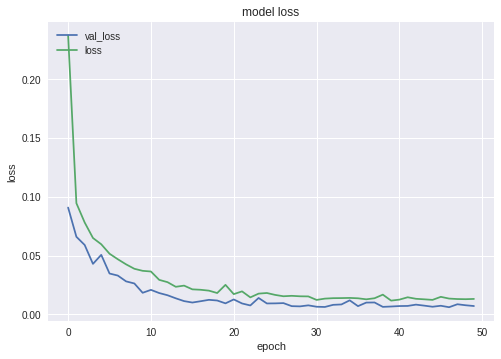

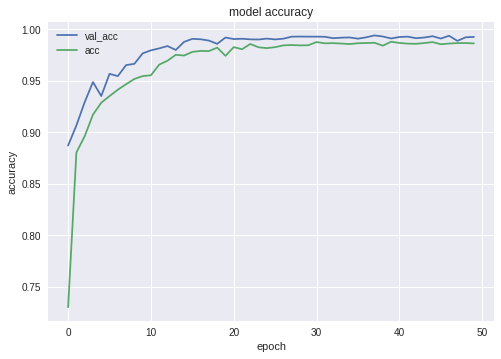

In [18]:
EPOCHS = 50
BATCH_SIZE = 275


model = models.Sequential()
model.add(layers.Dense(1024, activation='relu',
                       input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(160, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(y_train.shape[1],activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])



history = model.fit(X_train, y_train,verbose=1, validation_data=(X_test,y_test), epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()




```

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu',
                       input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(160, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(y_train.shape[1],activation='softmax'))```



Test accuracy: 0.9949977262391997


## tokenの保存

In [0]:
save_text_tokenizer(tag_token,base_dir+"tag_token")
save_text_tokenizer(iid_token,base_dir+"iid_token")
save_text_tokenizer(style_token,base_dir+"style_token")
save_text_tokenizer(href_token,base_dir+"href_token")
save_text_tokenizer(src_token,base_dir+"src_token")
save_text_tokenizer(alt_token,base_dir+"alt_token")
save_text_tokenizer(text_token,base_dir+"text_token")

## Tokenisor を読み込む

In [0]:
tag_token = load_text_tokenizer(base_dir+"tag_token")
iid_token = load_text_tokenizer(base_dir+"iid_token")
style_token = load_text_tokenizer(base_dir+"style_token")
href_token = load_text_tokenizer(base_dir+"href_token")
src_token = load_text_tokenizer(base_dir+"src_token")
alt_token = load_text_tokenizer(base_dir+"alt_token")
text_token = load_text_tokenizer(base_dir+"text_token")

## モデルと重みを保存する

###モデルを保存


In [0]:
model_json = model.to_json()
with open(base_dir + "model.json", "w") as json_file:
    json_file.write(model_json)
    
with open(base_dir + "model.h5",'w') as model_file: 
  model.save_weights(base_dir+"model.h5")

###モデルを読み込み

In [0]:
# load
with open(base_dir+'model.json', 'r') as json_file:
  loaded_model_json = json_file.read()
  loaded_model = model_from_json(loaded_model_json)

with open(base_dir+"model.h5",'r') as model_file: 
  loaded_model.load_weights(base_dir+"model.h5")
  print("Loaded model from disk")

# compile
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])


Loaded model from disk


###モデルの復元が正確かを確認

In [0]:
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.013336440061516349
Test accuracy: 0.9910413824465666


## 実際のデータでテスト